In [1]:
from utils.models import CNNDiscriminator, Generator

In [2]:
from utils.data import ECGDataset, save_ecg_example

In [3]:
import pickle

In [4]:
from torch.utils.data import DataLoader

In [5]:
ecg_dataset = ECGDataset(pickle.load(open("./data/icbeb_data.pickle",'rb')), 
                         "./data/icbeb_labels.csv", 
                         device='cpu')

In [6]:
import torch.nn as nn
import tqdm

In [7]:
real_data_loader = DataLoader(ecg_dataset, batch_size=24, drop_last=True, shuffle=True)

In [8]:
G = Generator(labels_dim=7,
                  hidden_dim=128,
                  latent_dim=100,
                  batch_size=24,
                  device='cuda:1',
                  decoder_output_dim=12,
                  dataset_for_labels=ecg_dataset)


In [12]:
from torch.utils.tensorboard import SummaryWriter
import os
import torch

In [13]:
G_nogan_criterion = nn.MSELoss()
G_nogan_optimizer = torch.optim.Adam(G.parameters(), lr=0.0005)
tb_writer = SummaryWriter(os.path.join("./out/tensorboard", "mse_gan_test_small_ecg"))

In [14]:
for i in tqdm.tqdm_notebook(range(10), position=0):
    for seqs, labels in tqdm.tqdm_notebook(real_data_loader, position=1):
        fake_seqs, _, _ = G.generate_seq_batch_for_given_labels_and_lenghts( [seqs.size(1)] * 24, labels)
        loss = G_nogan_criterion(fake_seqs, seqs.to('cuda:1'))
        tb_writer.add_scalar("G_MSE_loss", loss.item(),i)
        loss.backward()
        G_nogan_optimizer.step()
        G.zero_grad()
    with torch.no_grad():
        fake_seqs, _, _ = G.generate_seq_batch_for_given_labels_and_lenghts( [seqs.size(1)] * 24, labels)
        tb_writer.add_figure("gen_example", save_ecg_example(fake_seqs[0].detach().cpu().numpy(),f"mse_gan_epoch_{i}", f'epoch_{i}'))

In [15]:
checkpoint = torch.load(open("./out/models/large_cnn_gan_epoch_95_checkpoint.pkl", 'rb'), map_location="cuda:1")

/out_world/university/ecg_gen/venv/lib/python3.6/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'utils.models.Generator' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [16]:
trained_G = checkpoint['g_model']
trained_G.device ="cuda:1"

In [17]:
trained_G_nogan_criterion = nn.MSELoss()
trained_G_nogan_optimizer = torch.optim.Adam(trained_G.parameters())
trained_G_tb_writer = SummaryWriter(os.path.join("./out/tensorboard", "mse_trained_gan_test_fixed_target_small"))

In [18]:
seqs, labels = [it for it in real_data_loader][3]

In [46]:
for i in tqdm.tqdm_notebook(range(10000), position=0):
#     for seqs, labels in tqdm.tqdm_notebook(real_data_loader, position=1):
    fake_seqs, _, _ = trained_G.generate_seq_batch_for_given_labels_and_lenghts( [seqs.size(1)] * 24, labels)
    loss = trained_G_nogan_criterion(fake_seqs, seqs.to('cuda:1'))
    trained_G_tb_writer.add_scalar("G_MSE_loss", loss.item(),i)
    loss.backward()
    trained_G_nogan_optimizer.step()
    trained_G.zero_grad()
#     if i % 10 == 9:
#         with torch.no_grad():
#             fake_seqs, _, _ = trained_G.generate_seq_batch_for_given_labels_and_lenghts( [seqs.size(1)] * 24, labels)
#             trained_G_tb_writer.add_figure("gen_example", save_ecg_example(fake_seqs[0].detach().cpu().numpy(),f"mse_gan_epoch_{i}", f'epoch_{i}'),i)

In [ ]:
# after 1k steps on fixed 

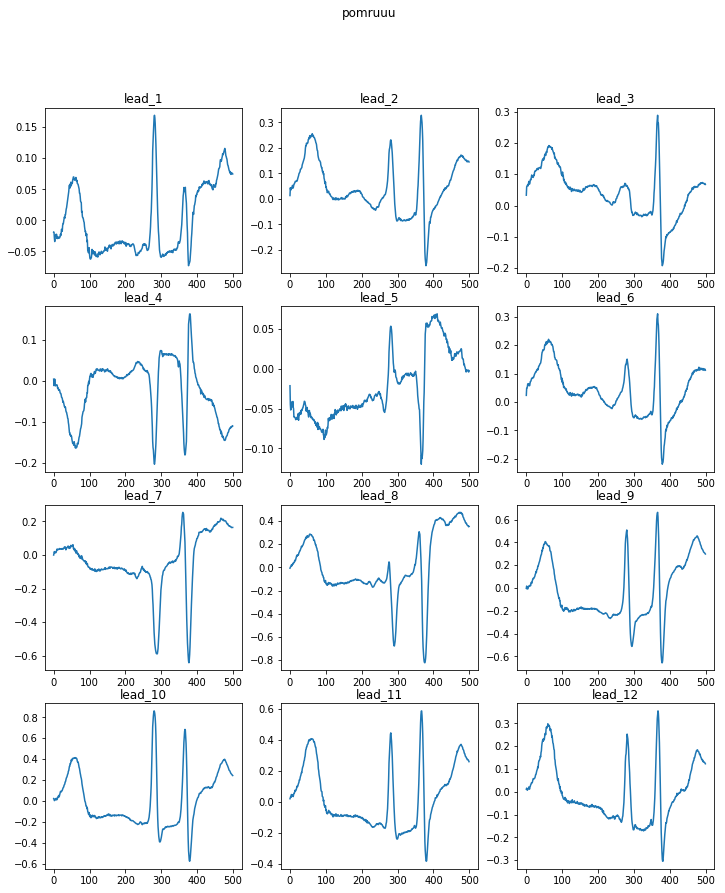

In [49]:
fake_seqs, _, _ = trained_G.generate_seq_batch_for_given_labels_and_lenghts( [seqs.size(1)] * 24, labels)
save_ecg_example(fake_seqs[5].detach().cpu().numpy(),f"ya_shas_pomru", f'pomruuu')

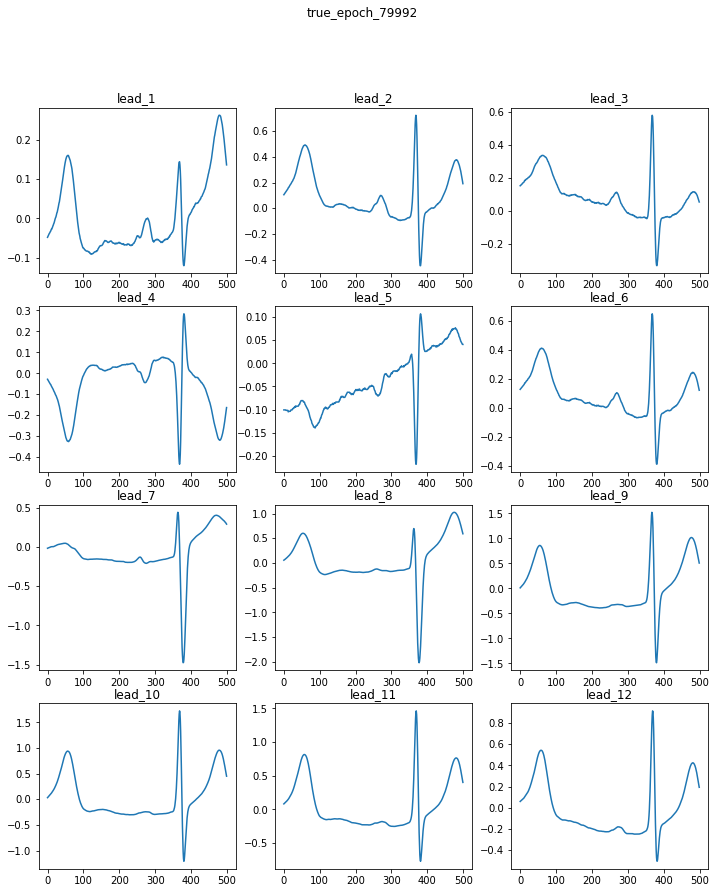

In [50]:
save_ecg_example(seqs[5].detach().cpu().numpy(),f"true_mse_gan_epoch_{i*8}", f'true_epoch_{i*8}')

In [52]:
checkpoint['g_model'] = trained_G

In [53]:
torch.save(checkpoint, "./out/models/pretrained_generator_20k_epochs")

In [26]:
t_fake_seqs, _, _ = trained_G.generate_seq_batch_for_given_labels_and_lenghts( [seqs.size(1)] * 24, labels)

In [27]:
G_nogan_criterion(t_fake_seqs, seqs.to('cuda:1'))

tensor(0.1084, device='cuda:1', grad_fn=<MseLossBackward>)

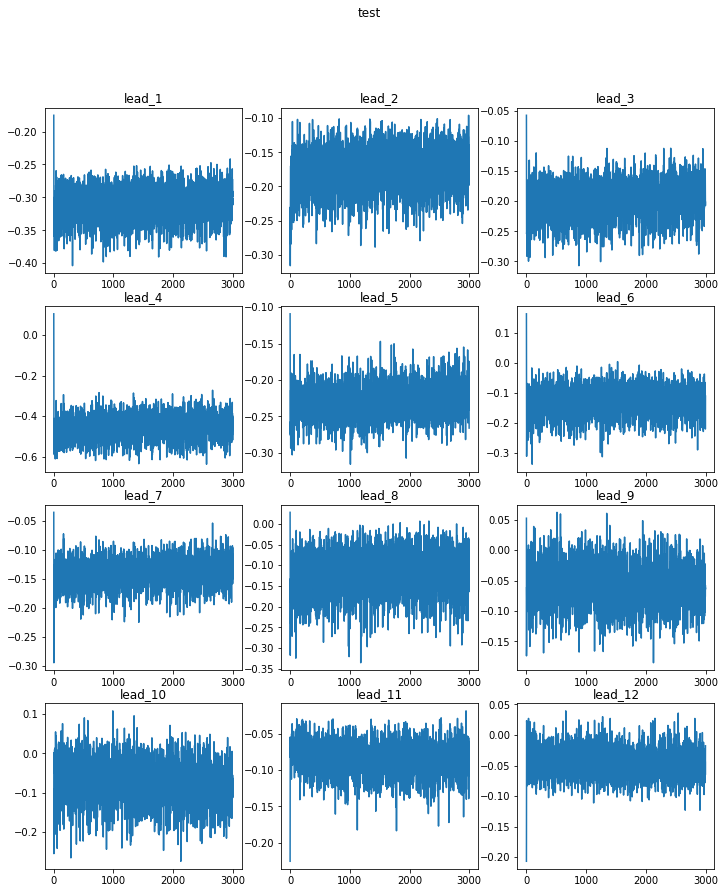

In [33]:
save_ecg_example(t_fake_seqs[0].detach().cpu().numpy(),'test', 'test')

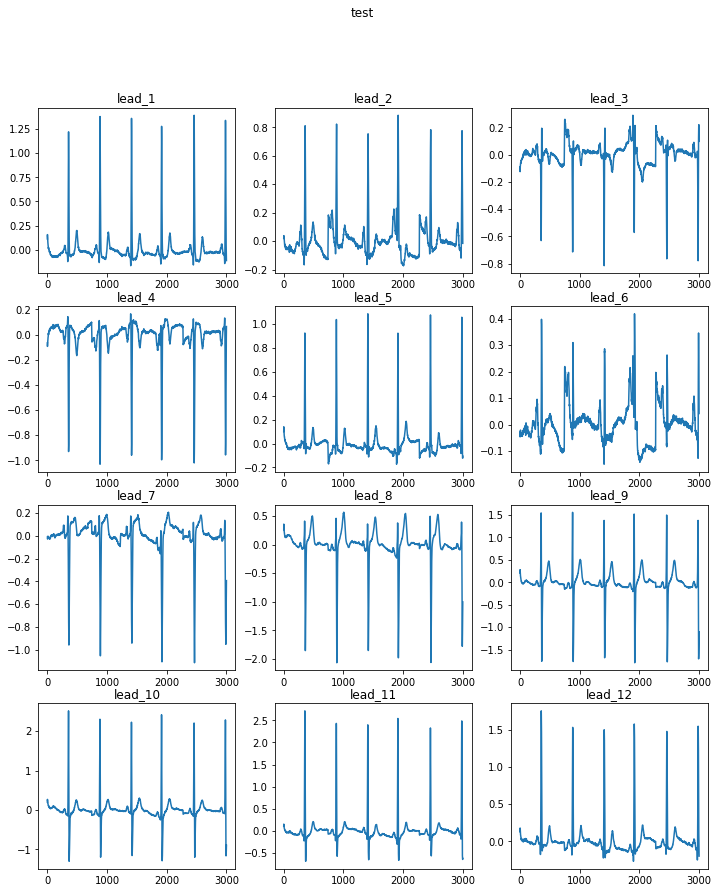

In [34]:
save_ecg_example(seqs[0].detach().cpu().numpy(),'test', 'test')